# A Distributional Code for Value

In [1]:
# Uncomment below lines and run this cell to install neuronav and requirements for colab.

#!git clone https://github.com/awjuliani/neuro-nav
#!pip install ./neuro-nav[experiments_remote]

In [2]:
from neuronav.envs.graph_env import GraphEnv
from neuronav.agents.dist_agents import DistQ
from neuronav.envs.graph_structures import GraphStructure
from neuronav.utils import run_episode
import matplotlib.pyplot as plt
import numpy as np

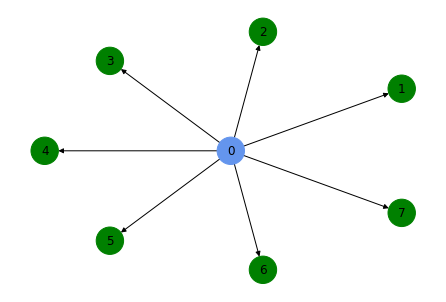

In [3]:
env = GraphEnv(graph_structure=GraphStructure.variable_magnitude)
obs = env.reset()
env.render()

In [4]:
num_episodes = 25000
num_steps = 1

agent = DistQ(env.state_size, env.action_space.n, dist_cells=150)
total_steps = []
for i in range(num_episodes):
    agent, steps = run_episode(env, agent, max_steps=num_steps)
    total_steps.append(steps)

dist = agent.Q[0,  0]

Text(0, 0.5, 'Value Estimate')

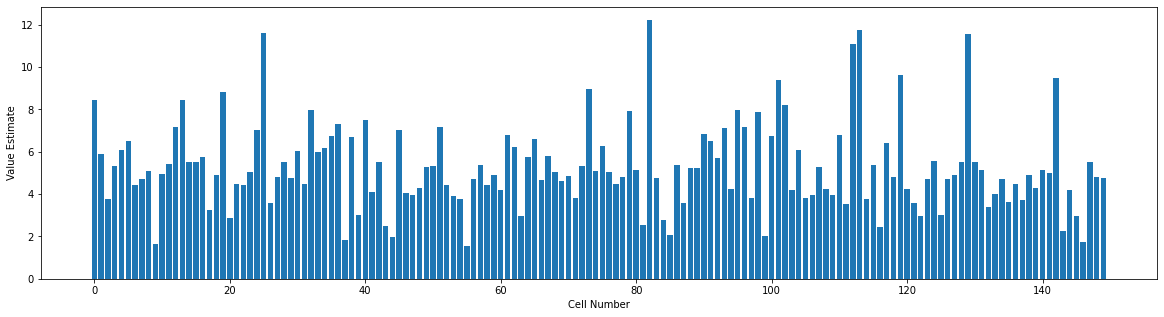

In [5]:
plt.figure(figsize=(20, 5))
plt.bar(np.arange(0, agent.dist_cells), dist)
plt.xlabel("Cell Number")
plt.ylabel("Value Estimate")

In [6]:
rewards = np.array([0.1, 0.3, 1.2, 2.5, 5, 10, 20])
lr_floor = 0.2

rpes = []
lrp = lr_floor + agent.lrs_pos
lrn = lr_floor + agent.lrs_neg
for reward in rewards:
    q_error = reward - dist
    qep = (q_error > 0.0) * 1.0
    rpe = (lrp * qep + lrn * (1 - qep)) * q_error
    rpes.append(rpe)
rpes = np.stack(rpes)

In [7]:
sort_ids = np.argsort(dist)
sorted_rpes = rpes[:, sort_ids]
sorted_rpes /= sorted_rpes.std(1, keepdims=True)
sorted_rpes = sorted_rpes[:,::5]

Text(0.5, 0, 'RPE (Normalized)')

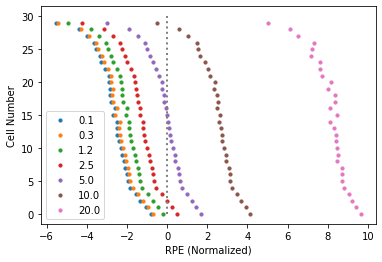

In [8]:
for i in range(len(rewards)):
    plt.scatter(sorted_rpes[i, :], np.arange(0, sorted_rpes.shape[-1]), s=10, label=rewards[i])
plt.vlines(x=0, ymin=0, ymax=sorted_rpes.shape[-1], colors="gray", ls=":", lw=2)
plt.legend()
plt.ylabel("Cell Number")
plt.xlabel("RPE (Normalized)")